# Importing Libraries

In [1]:
import math
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# Create sub-circuit for Entanglement-Swapping

In [2]:
sub_q = QuantumRegister(3)
sub_circ = QuantumCircuit(sub_q, name='e\ns')

sub_circ.cx(sub_q[0], sub_q[1])
sub_circ.h(sub_q[0])
sub_circ.cx(sub_q[1], sub_q[2])
sub_circ.cz(sub_q[0], sub_q[2])

ent_swap = sub_circ.to_instruction()

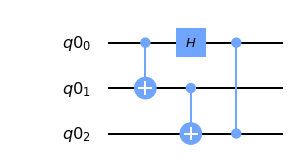

In [3]:
sub_circ.draw(output='mpl')

# Preparing Quantum-Repeater Circuit

In [4]:
# preparing registers
users = QuantumRegister(6, 'alice & bob')
channel = QuantumRegister(6, 'channel')
distance = QuantumRegister(3, 'distance')
checks = ClassicalRegister(6)

In [5]:
# constructing circuit

sys = QuantumCircuit(users, channel, distance, checks)

In [6]:
# creating bell-pairs

for i in range(0, 6):
    sys.h(users[i])
    sys.cx(users[i], channel[i])

sys.barrier()

In [7]:
# emulating travelling through distant channel
for i in range(0, 3):
    sys.swap(channel[2*i], distance[i])

sys.barrier()

In [8]:
# entanglement swapping
for i in range(0, 3):
    sys.append(ent_swap, [distance[i], channel[2*i+1], users[2*i+1]])

sys.barrier()

In [9]:
#Deutsch's Correction 

#rotation-Alice
for i in range(0, 6, 2):
    sys.rx(pi/2, users[i])
    sys.rx(-pi/2, users[i+1])

sys.barrier()

In [10]:
# Bennett's Protocol

for i in range(2, 6, 2):
    sys.cx(users[0], users[i])
    sys.cx(users[1], users[i+1])    
sys.barrier()

In [11]:
#checking fidelity through bell-measurement

sys.cx(users[0], users[1])
sys.h(users[0])
sys.barrier()

In [12]:
#distillation
sys.measure(users, checks)

C:\Users\sdas_\Anaconda3\lib\site-packages\qiskit\visualization\matplotlib.py:144: DeprecationWarning: style option/s (fold) is/are not supported
  self._style.set_style(style)


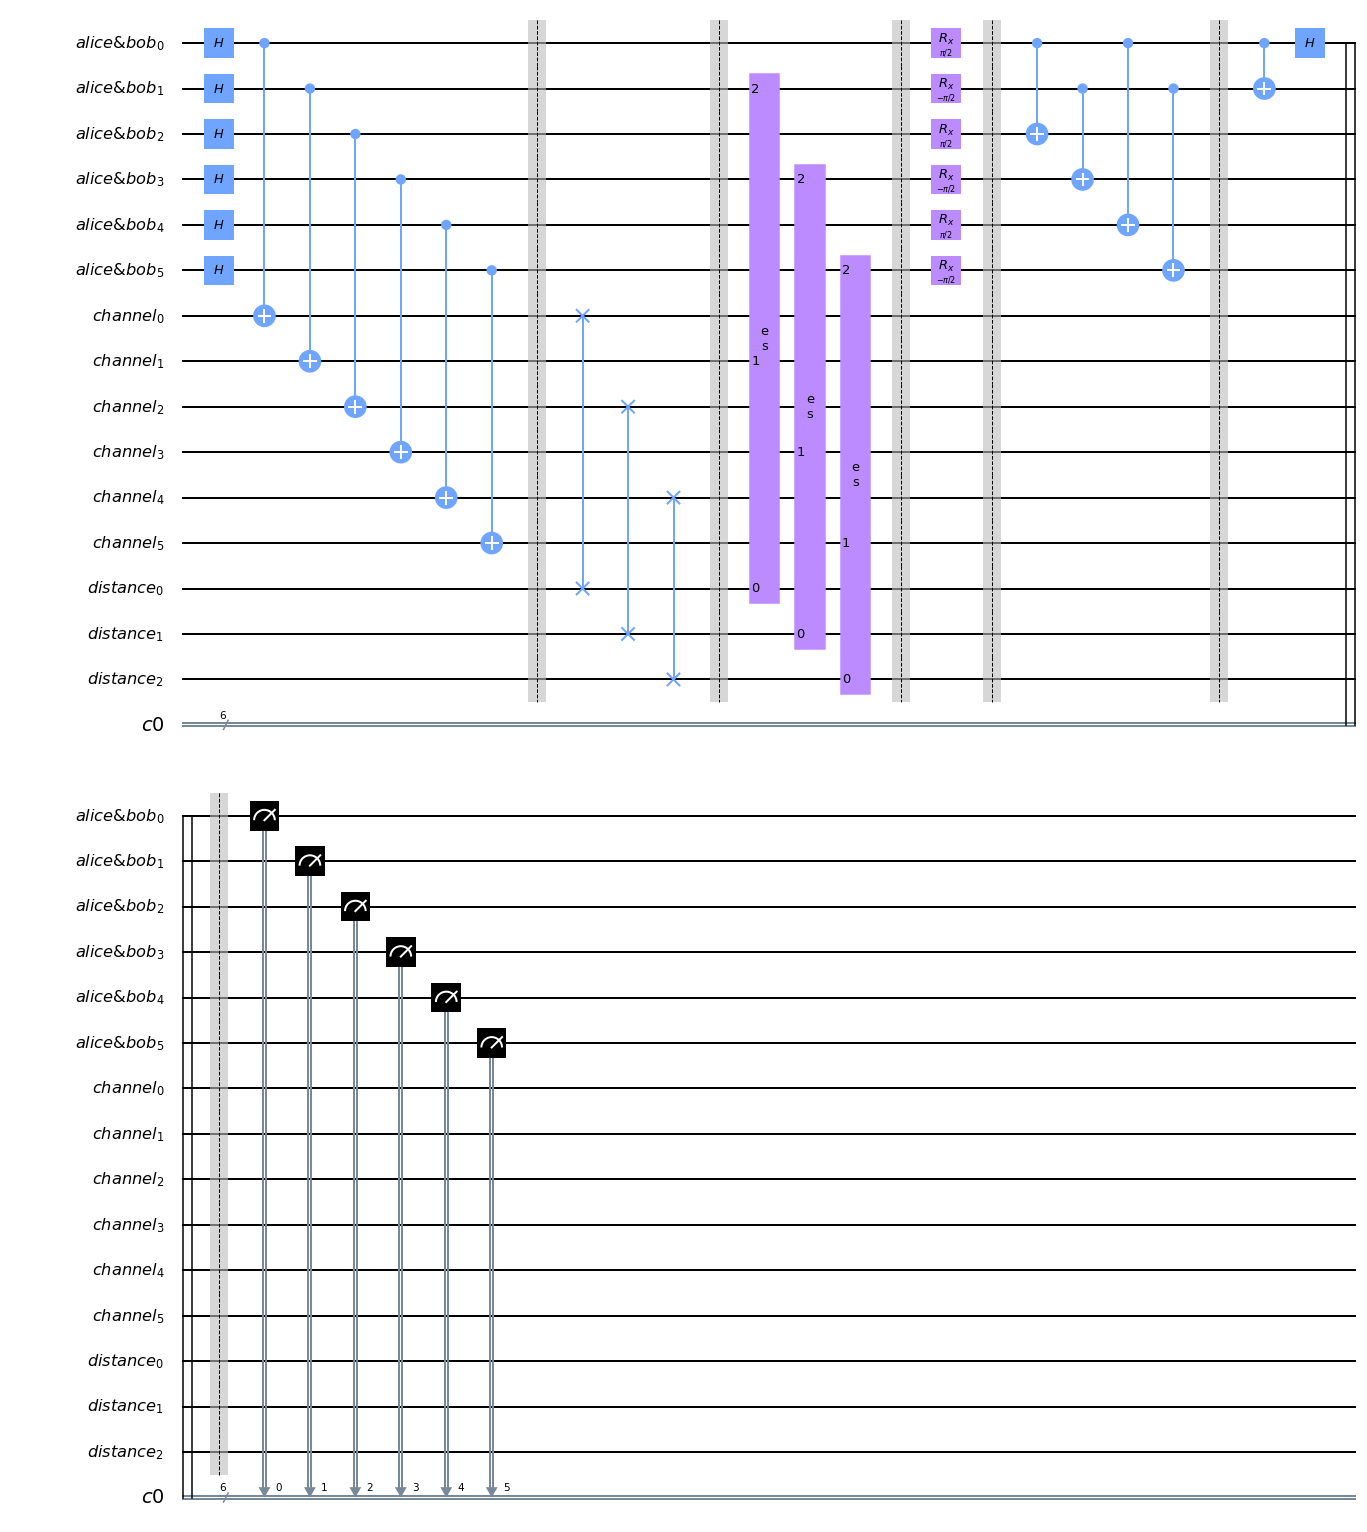

In [13]:
style = {'fold':40}
sys.draw(output='mpl', style=style)

# Running on Real Device

In [14]:
from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')

In [15]:
from qiskit import execute
from qiskit.tools.monitor import job_monitor

In [18]:
shots = 8192
job = execute(sys, backend=device, shots=shots, optimization_level=0)

print(job.job_id())
job_monitor(job)

5eec96b46bb14a001cca0671
Job Status: job has successfully run


In [19]:
device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)

{'011101': 56, '001101': 107, '101011': 117, '010110': 103, '011011': 69, '000000': 309, '011111': 51, '100100': 164, '100110': 162, '111001': 64, '110110': 98, '100011': 212, '111100': 34, '101010': 92, '000111': 179, '100000': 258, '101100': 81, '101001': 107, '010001': 187, '010111': 110, '010100': 130, '110010': 112, '111010': 56, '001011': 122, '111110': 31, '111101': 30, '011001': 64, '000010': 296, '111011': 48, '110000': 148, '000001': 316, '100010': 232, '110001': 143, '111000': 65, '011010': 71, '101110': 79, '010101': 122, '011000': 90, '101111': 83, '001100': 81, '110011': 152, '110101': 101, '001000': 119, '001110': 77, '100111': 153, '110100': 108, '011100': 57, '101101': 85, '001010': 113, '000100': 210, '101000': 118, '001001': 130, '100101': 156, '010000': 172, '000011': 290, '111111': 47, '000110': 188, '110111': 68, '010010': 166, '011110': 46, '000101': 244, '010011': 178, '100001': 254, '001111': 81}


# Measurement Error Mitigation

In [20]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

## Generating Calibration Circuit and Filter

In [21]:
#generating calibration circuits
cal_circuits, state_labels = complete_meas_cal(qr=sys.qregs[0],
                                               circlabel='measurement_calibration')

In [22]:
# running calibration circuits
cal_job = execute(cal_circuits, 
                  backend=device, shots=8192, optimization_level=0)

print(cal_job.job_id())
job_monitor(cal_job)

5eec981dbc8e9400199b6c4d
Job Status: job has successfully run


In [23]:
cal_results = cal_job.result()

In [24]:
# creating mitigation filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

## Mitigating Error

In [25]:
# error mitigation
mitigated_result = meas_filter.apply(device_result)
mitigated_counts = mitigated_result.get_counts()

print(mitigated_counts)

{'000101': 209.07976862371822, '001010': 87.94815038866764, '110011': 219.3150456386044, '111010': 81.20340918992707, '100011': 231.1279404698519, '010100': 112.07640721493533, '101011': 157.39728671038728, '111111': 86.07134909091253, '011101': 64.40325315220639, '010101': 106.93484483335038, '000001': 214.4657372755986, '110001': 170.2009642186855, '100111': 207.5414382096616, '010001': 155.60288049695978, '101110': 113.12176097536398, '110010': 129.82367692827205, '000110': 146.88624399099393, '011011': 69.46085762592486, '101100': 106.8181838456765, '000111': 142.24741767112766, '111100': 49.970192478718964, '111011': 68.28130526190401, '001111': 68.38279504429218, '110000': 176.9539039131178, '111001': 93.41698452099777, '010010': 143.15898278046257, '010011': 150.7387671700262, '101001': 124.49464978784756, '100000': 266.2460784993501, '100010': 254.0114425665368, '110111': 99.72866789568025, '000010': 207.00252595368377, '001110': 63.82573815909044, '111000': 86.32269523393173, 

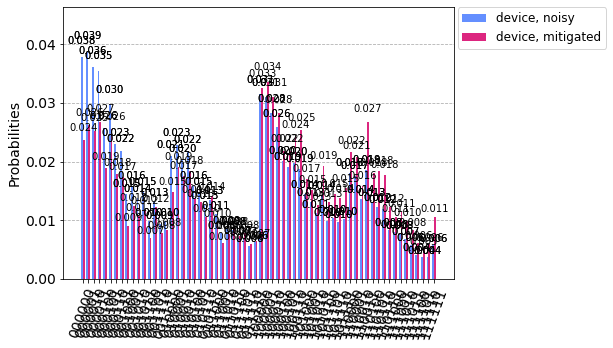

In [26]:
from qiskit.visualization import plot_histogram

plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])